##  Deep Learning – Assignment 1: Single-Word Audio Classification (FNN)

# Library


In [1]:
!nvidia-smi

Fri May  2 22:42:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              9W /   75W |     163MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Setting

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Audio Parameters
SAMPLE_RATE = 16000  # 16kHz sample rate
N_MFCC = 40          # Number of MFCC features
N_FFT = 400          # FFT window size
HOP_LENGTH = 160     # Hop length for STFT

# Path for audio data
TRAIN_AUDIO_PATH = 'Data_People/Training/'
TEST_AUDIO_PATH = 'Data_People/Testing/'

# Classes for classification
classes = ["SUBHANALLAH", "ALLAHUAKBAR", "ALHAMDULLILAH"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for idx, cls in enumerate(classes)}

Using device: cuda


# Dataset & Feature Extraction

In [4]:
# Audio Dataset Class
class AudioWordDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the audio files.
        """
        self.root_dir = Path(root_dir)
        self.samples = []
        
        # Check if the root directory exists
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Directory {root_dir} does not exist")
        
        # Walk through all files in directory
        for word_dir in self.root_dir.iterdir():
            if word_dir.is_dir() and word_dir.name in classes:
                word_class = word_dir.name
                for audio_file in word_dir.glob('*.wav'):
                    self.samples.append((str(audio_file), class_to_idx[word_class]))
        
        if len(self.samples) == 0:
            print(f"Warning: No audio files found in {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            audio_path, label = self.samples[idx]
            
            # Load audio with error handling
            try:
                waveform, sample_rate = torchaudio.load(audio_path)
            except Exception as e:
                print(f"Error loading audio file {audio_path}: {e}")
                # Return a dummy waveform and the label
                return torch.zeros(1, 16000), label
            
            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Ensure minimum length
            if waveform.shape[1] < 1000:  # Arbitrary minimum length
                waveform = torch.nn.functional.pad(waveform, (0, 1000 - waveform.shape[1]))
            
            # Limit maximum length to avoid memory issues
            max_length = 16000 * 5  # ~5 seconds at 16kHz
            if waveform.shape[1] > max_length:
                waveform = waveform[:, :max_length]
            
            # Extract MFCC features directly here to simplify the pipeline
            mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=sample_rate,
                n_mfcc=N_MFCC,
                melkwargs={
                    'n_fft': N_FFT,
                    'n_mels': 128,
                    'hop_length': HOP_LENGTH,
                }
            )
            
            # Extract features and normalize
            mfcc = mfcc_transform(waveform)
            mean = mfcc.mean()
            std = mfcc.std()
            mfcc = (mfcc - mean) / (std + 1e-10)
            
            return mfcc, label
        
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Return a dummy tensor and the label
            return torch.zeros(N_MFCC, 100), 0

# CNN

In [6]:
class AudioCNN(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, n_classes=len(classes)):
        super(AudioCNN, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        
        # Adaptive pooling to handle variable size inputs
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # FC layers with fixed input size due to adaptive pooling
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc_relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, n_classes)
    
    def forward(self, x):
        # Add channel dimension if necessary
        if x.dim() == 3:  # [batch, mfcc, time]
            x = x.unsqueeze(1)  # [batch, 1, mfcc, time]
        
        # CNN
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        # Adaptive pooling to handle variable sizes
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [7]:
# collate function for DataLoader
def collate_fn(batch):
    # filter out None values
    batch = [(mfcc, label) for mfcc, label in batch if mfcc is not None]
    
    if len(batch) == 0:
        return torch.zeros(0, 1, N_MFCC, 100).to(device), torch.zeros(0).long().to(device)
    
    # Separate features and labels
    features, labels = zip(*batch)
    
    # Max length in the time dimension
    max_length = max([feature.shape[2] for feature in features])
    
    # Pad sequences to max length
    padded_features = []
    for feature in features:
        padding_size = max_length - feature.shape[2]
        if padding_size > 0:
            padded_feature = torch.nn.functional.pad(feature, (0, padding_size))
        else:
            padded_feature = feature
        padded_features.append(padded_feature)
    
    # Stack tensors
    features_tensor = torch.stack(padded_features)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return features_tensor, labels_tensor


# Data Loader


In [8]:
def create_dataloaders(batch_size=16):
    try:
        train_dataset = AudioWordDataset(TRAIN_AUDIO_PATH)
        test_dataset = AudioWordDataset(TEST_AUDIO_PATH)
        
        print(f"Training samples: {len(train_dataset)}")
        print(f"Testing samples: {len(test_dataset)}")
        
        if len(train_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("One or both datasets are empty")
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,  
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,  
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise


# Train & Validate

In [9]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset) # type: ignore

def validate(model, val_loader, loss_fn, device, return_preds=False):
    model.eval()
    val_loss, val_correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

            if return_preds:
                y_true.extend(labels.cpu().tolist())
                y_pred.extend(predictions.cpu().tolist())

    if return_preds:
        return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset), y_pred, y_true # type: ignore
    else:
        return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset) # type: ignore


def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda', patience=10):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    best_val_accuracy = 0.0
    counter = 0

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        # Training for one epoch
        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device) # type: ignore

        # Update history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        # Display training progress
        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

        # Early stopping based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            counter = 0
            # Save the model with the best validation accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load the best model before returning
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history




# Analysis

In [10]:
# Plot metrics

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(train_accs, label='Training Accuracy')
        ax2.plot(val_accs, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")


In [11]:
# Plot confusion matrix

def plot_confusion_matrix(y_true, y_pred):
    try:
        if len(y_true) == 0 or len(y_pred) == 0:
            print("No data to create confusion matrix")
            return
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate class-wise accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        for i, acc in enumerate(class_acc):
            print(f'Accuracy for class {idx_to_class[i]}: {acc:.2f}%')
        
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")


# Main

In [12]:
# Hyperparameters

batch_size = 8  
learning_rate = 0.003
num_epochs = 50

In [ ]:
# Create data loaders with error handling

train_loader, test_loader = create_dataloaders(batch_size) 

Training samples: 72
Testing samples: 18


In [14]:
# Sample a batch to verify data shape before proceeding

for inputs, labels in train_loader:
    print(f"Sample batch shape: {inputs.shape}, Labels: {labels.shape}")
    break

Sample batch shape: torch.Size([8, 1, 40, 360]), Labels: torch.Size([8])


In [15]:

model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs, device) # type: ignore


Training Progress:   2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch 1/50: Train loss: 1.1224, Train accuracy: 0.3472, Val loss: 1.1209, Val accuracy: 0.4444, Time: 0.78s


Training Progress:   4%|▍         | 2/50 [00:01<00:38,  1.24it/s]

Epoch 2/50: Train loss: 1.0819, Train accuracy: 0.4306, Val loss: 1.1108, Val accuracy: 0.2222, Time: 0.80s


Training Progress:   6%|▌         | 3/50 [00:02<00:36,  1.27it/s]

Epoch 3/50: Train loss: 1.1064, Train accuracy: 0.3750, Val loss: 1.1257, Val accuracy: 0.2778, Time: 0.75s


Training Progress:   8%|▊         | 4/50 [00:02<00:32,  1.42it/s]

Epoch 4/50: Train loss: 1.1482, Train accuracy: 0.3611, Val loss: 1.1207, Val accuracy: 0.5000, Time: 0.56s


Training Progress:  10%|█         | 5/50 [00:03<00:30,  1.49it/s]

Epoch 5/50: Train loss: 1.0766, Train accuracy: 0.3472, Val loss: 1.1108, Val accuracy: 0.3333, Time: 0.61s


Training Progress:  12%|█▏        | 6/50 [00:04<00:30,  1.45it/s]

Epoch 6/50: Train loss: 1.0857, Train accuracy: 0.4306, Val loss: 1.1363, Val accuracy: 0.5000, Time: 0.72s


Training Progress:  14%|█▍        | 7/50 [00:04<00:28,  1.51it/s]

Epoch 7/50: Train loss: 1.0405, Train accuracy: 0.5139, Val loss: 1.0956, Val accuracy: 0.3889, Time: 0.60s


Training Progress:  16%|█▌        | 8/50 [00:05<00:26,  1.56it/s]

Epoch 8/50: Train loss: 1.0075, Train accuracy: 0.4444, Val loss: 1.1021, Val accuracy: 0.4444, Time: 0.59s


Training Progress:  18%|█▊        | 9/50 [00:06<00:26,  1.55it/s]

Epoch 9/50: Train loss: 1.0218, Train accuracy: 0.4583, Val loss: 1.0295, Val accuracy: 0.5000, Time: 0.65s


Training Progress:  20%|██        | 10/50 [00:07<00:29,  1.34it/s]

Epoch 10/50: Train loss: 0.8607, Train accuracy: 0.6111, Val loss: 0.9045, Val accuracy: 0.5000, Time: 0.97s


Training Progress:  22%|██▏       | 11/50 [00:08<00:31,  1.25it/s]

Epoch 11/50: Train loss: 0.7750, Train accuracy: 0.6667, Val loss: 0.7096, Val accuracy: 0.6667, Time: 0.91s


Training Progress:  24%|██▍       | 12/50 [00:08<00:29,  1.27it/s]

Epoch 12/50: Train loss: 0.5122, Train accuracy: 0.7778, Val loss: 0.5841, Val accuracy: 0.7778, Time: 0.73s


Training Progress:  26%|██▌       | 13/50 [00:09<00:28,  1.29it/s]

Epoch 13/50: Train loss: 0.5773, Train accuracy: 0.7083, Val loss: 0.4457, Val accuracy: 0.7222, Time: 0.74s


Training Progress:  28%|██▊       | 14/50 [00:10<00:27,  1.32it/s]

Epoch 14/50: Train loss: 0.5684, Train accuracy: 0.7222, Val loss: 0.7012, Val accuracy: 0.6111, Time: 0.72s


Training Progress:  30%|███       | 15/50 [00:11<00:26,  1.32it/s]

Epoch 15/50: Train loss: 0.5106, Train accuracy: 0.7222, Val loss: 0.3313, Val accuracy: 0.8889, Time: 0.73s


Training Progress:  32%|███▏      | 16/50 [00:11<00:24,  1.40it/s]

Epoch 16/50: Train loss: 0.4231, Train accuracy: 0.8056, Val loss: 0.2367, Val accuracy: 0.9444, Time: 0.59s


Training Progress:  34%|███▍      | 17/50 [00:12<00:23,  1.39it/s]

Epoch 17/50: Train loss: 0.3991, Train accuracy: 0.8333, Val loss: 0.3451, Val accuracy: 0.8889, Time: 0.73s


Training Progress:  36%|███▌      | 18/50 [00:13<00:23,  1.33it/s]

Epoch 18/50: Train loss: 0.3047, Train accuracy: 0.9028, Val loss: 0.2960, Val accuracy: 0.8889, Time: 0.81s


Training Progress:  38%|███▊      | 19/50 [00:14<00:24,  1.24it/s]

Epoch 19/50: Train loss: 0.3722, Train accuracy: 0.7917, Val loss: 0.3815, Val accuracy: 0.8333, Time: 0.93s


Training Progress:  40%|████      | 20/50 [00:14<00:23,  1.26it/s]

Epoch 20/50: Train loss: 0.4229, Train accuracy: 0.8472, Val loss: 0.5808, Val accuracy: 0.7222, Time: 0.76s


Training Progress:  42%|████▏     | 21/50 [00:15<00:23,  1.25it/s]

Epoch 21/50: Train loss: 0.3151, Train accuracy: 0.8611, Val loss: 0.7839, Val accuracy: 0.6667, Time: 0.80s


Training Progress:  44%|████▍     | 22/50 [00:16<00:21,  1.27it/s]

Epoch 22/50: Train loss: 0.2631, Train accuracy: 0.8750, Val loss: 0.1397, Val accuracy: 1.0000, Time: 0.73s


Training Progress:  46%|████▌     | 23/50 [00:17<00:21,  1.26it/s]

Epoch 23/50: Train loss: 0.3924, Train accuracy: 0.8056, Val loss: 0.1064, Val accuracy: 1.0000, Time: 0.81s


Training Progress:  48%|████▊     | 24/50 [00:18<00:20,  1.27it/s]

Epoch 24/50: Train loss: 0.3061, Train accuracy: 0.8611, Val loss: 0.1948, Val accuracy: 0.9444, Time: 0.75s


Training Progress:  50%|█████     | 25/50 [00:18<00:19,  1.30it/s]

Epoch 25/50: Train loss: 0.1826, Train accuracy: 0.9444, Val loss: 0.1148, Val accuracy: 1.0000, Time: 0.72s


Training Progress:  52%|█████▏    | 26/50 [00:19<00:17,  1.39it/s]

Epoch 26/50: Train loss: 0.2530, Train accuracy: 0.8889, Val loss: 0.0887, Val accuracy: 1.0000, Time: 0.61s


Training Progress:  54%|█████▍    | 27/50 [00:20<00:18,  1.26it/s]

Epoch 27/50: Train loss: 0.2519, Train accuracy: 0.9167, Val loss: 0.1900, Val accuracy: 1.0000, Time: 0.95s


Training Progress:  56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

Epoch 28/50: Train loss: 0.2615, Train accuracy: 0.8333, Val loss: 0.4794, Val accuracy: 0.6667, Time: 0.75s


Training Progress:  58%|█████▊    | 29/50 [00:21<00:16,  1.31it/s]

Epoch 29/50: Train loss: 0.1725, Train accuracy: 0.9583, Val loss: 0.2714, Val accuracy: 0.7778, Time: 0.72s


Training Progress:  60%|██████    | 30/50 [00:22<00:15,  1.28it/s]

Epoch 30/50: Train loss: 0.2137, Train accuracy: 0.9167, Val loss: 0.0730, Val accuracy: 1.0000, Time: 0.81s


Training Progress:  62%|██████▏   | 31/50 [00:23<00:16,  1.18it/s]

Epoch 31/50: Train loss: 0.2020, Train accuracy: 0.9444, Val loss: 0.0957, Val accuracy: 1.0000, Time: 1.01s


Training Progress:  62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

Epoch 32/50: Train loss: 0.1981, Train accuracy: 0.9028, Val loss: 0.1002, Val accuracy: 1.0000, Time: 0.87s
Early stopping triggered at epoch 32


Test Loss: 0.1397
Test Accuracy: 1.0000


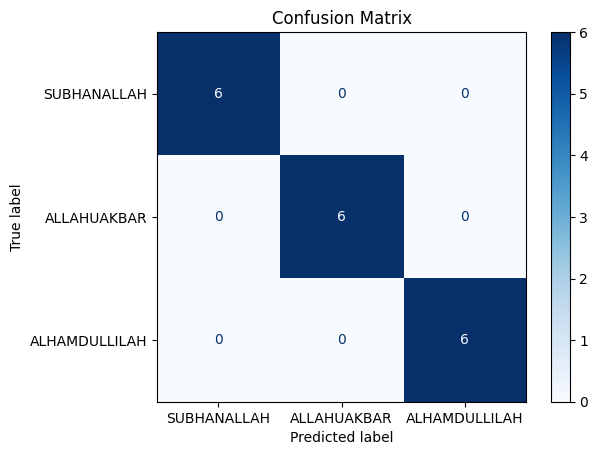

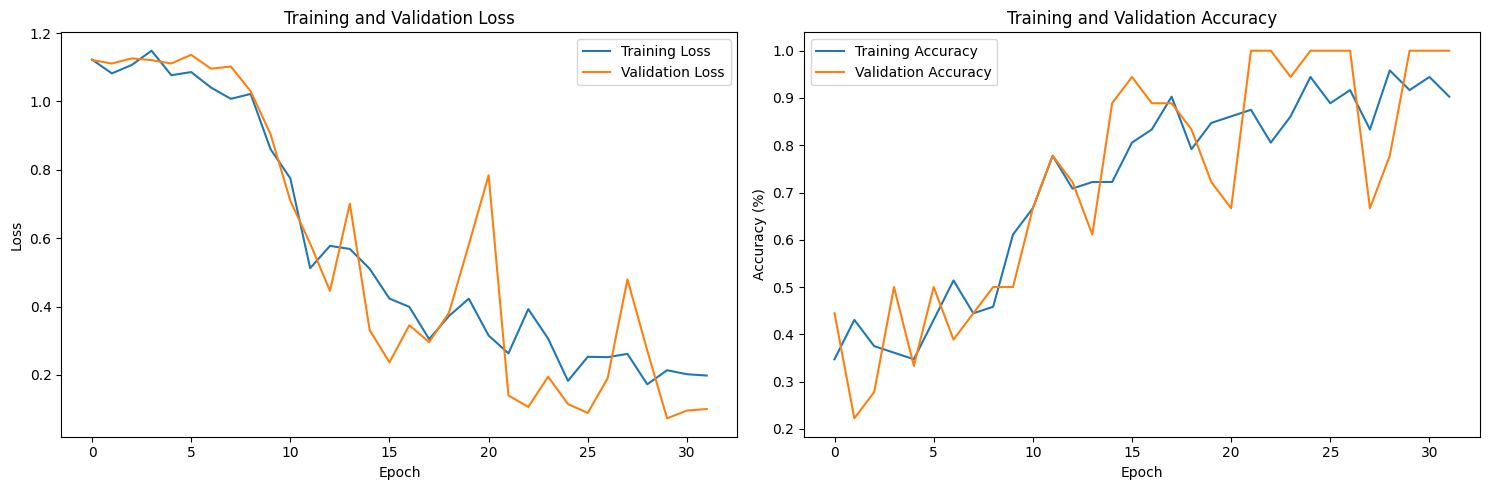

In [18]:
# Final evaluation on test set

val_loss, val_accuracy, y_pred, y_true = validate(model, test_loader, criterion, device, return_preds=True) # type: ignore

# Accuracy
print(f'Test Loss: {val_loss:.4f}')
print(f'Test Accuracy: {val_accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot training/validation metrics
plot_metrics(history['train_loss'], history['val_loss'],
             history['train_accuracy'], history['val_accuracy'])


# Discussion

This is my second model after learning CNN, for CNN it look like it perform much better and this is the one I spend most of the time with by debugging, the way this code work is by using CNN and then merge it with data loader with collate to merge the list into mini-list since the waveform might have different length. then by tuning the parameter I got this result. 

For the dataset, since I record using a phone via whatsapp so the file it come is Opus format. so an additional python code is needed to convert the opus to wav file format. Which can be view under "Convert.py". the way it work is basically using ffmpeg to convert opus file into wav

Data for this project can be get from here [Dataset](https://drive.google.com/drive/folders/1ddzV1WU-A-8O9MZezsYEl_nA8Fb5WX1b?usp=drive_link), it had multiple of folder which is training & testing which use as path for the model and Raw which had file before being convert(opus file format).


For Full Trial and error code is under [Github](https://github.com/KimieCrafter/AI-Note-IIUM), Thank You!!
